### Experimenting with Chr12 induced pairwise SVs 

The aim is to perform an in-depth study of the pairwise SVs for chr12, performing planned downstream analysis at multiple pairwise distance thresholds and for triangles, trapezoids, and parallelograms 

In [2]:
# Import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob


In [3]:
### This function reads in the SV bed files into a pandas DF for a given clade. 

def read_sv_bed_files(clade, chr, bed_folder):
    """
    Read all .bed files in a folder and add a 'clade' column to the data frame
    Each bed file has columns:
        sample1, start, end, sample2, start, end, type, diff
    """
    all_beds = []
    bed_files = [f for f in os.listdir(bed_folder) if f.endswith(".bed")]
    print(f"Found {len(bed_files)} SV bed files for clade '{clade}'")

    # Ensure folder exists
    if not os.path.isdir(bed_folder):
        raise FileNotFoundError("Folder not found for clade '{}': {}".format(clade, bed_folder))

    for filename in os.listdir(bed_folder):
        if filename.endswith(".bed"):
            bed_path = os.path.join(bed_folder, filename)
            try:
                df = pd.read_csv(
                    bed_path,
                    sep="\t",
                    header=None,
                    names=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff"]
                )
                df["clade"] = clade
                df["chr"] = chr
                df["source_file"] = filename  # optional, helps track origin
                df["length"] = np.where(
                    df["type"] == "I",
                    df["end2"] - df["start2"],  # insertion → use sample2 coords
                    df["end1"] - df["start1"]  # otherwise (deletion) → sample1 coords
                )
                all_beds.append(df)
            except Exception as e:
                print("Warning: Could not read {}: {}".format(bed_path, e))

    if all_beds:
        return pd.concat(all_beds, ignore_index=True)
    else:
        print("Warning: No .bed files found in {} for clade '{}'".format(bed_folder, clade))
        return pd.DataFrame(columns=["sample1", "start1", "end1", "sample2", "start2", "end2", "type", "diff", "clade", "source_file","chr"])

In [4]:
### read SV calls from both chr12 subgroups into dataframe and merge 
all_data = []
subgroup0 = read_sv_bed_files("subgroup_0", "chr12", "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/SV_beds/chr12_subgroup0")
all_data.append(subgroup0)
subgroup1 = read_sv_bed_files("subgroup_1", "chr12", "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/chr12/SV_beds/chr12_subgroup1")
all_data.append(subgroup1)

induced_df=pd.concat(all_data, ignore_index=True)

Found 17205 SV bed files for clade 'subgroup_0'
Found 17391 SV bed files for clade 'subgroup_1'


In [6]:
### Add pairwise distances as an additional column in the datafram 
pairwise_dist="/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/chr12_r2_QC_v2_centrolign_pairwise_distance.csv"

pairwise_df = pd.read_csv(pairwise_dist)
pairwise_df["chr"] = "chr12"
pairwise_df['dist'] = pairwise_df['dist'].astype(float)

# Sort sample pairs so ordering doesn't matter
df_dist_sorted = pairwise_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_sv_sorted = induced_df.copy()
df_sv_sorted[['sample1', 'sample2']] = np.sort(df_sv_sorted[['sample1', 'sample2']], axis=1)

# Merge on sample1, sample2, AND chr
df_sv_sorted = df_sv_sorted.merge(df_dist_sorted, on=['sample1', 'sample2', 'chr'], how='left')

df_sv_sorted.head()


,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,dist
0,HG02738.1,2773,3791,NA18570.2,2773,2774,D,0.001961,subgroup_0,chr12,HG02738.1_NA18570.2.bed,1018,0.789033
1,HG02738.1,3791,3792,NA18570.2,2773,3793,I,0.001961,subgroup_0,chr12,HG02738.1_NA18570.2.bed,1020,0.789033
2,HG02738.1,3866,8818,NA18570.2,3868,3869,D,0.205977,subgroup_0,chr12,HG02738.1_NA18570.2.bed,4952,0.789033
3,HG02738.1,8818,8819,NA18570.2,3868,7800,I,0.205977,subgroup_0,chr12,HG02738.1_NA18570.2.bed,3932,0.789033
4,HG02738.1,10274,10614,NA18570.2,9256,9257,D,-1.000000,subgroup_0,chr12,HG02738.1_NA18570.2.bed,340,0.789033


/data/tmp/ipykernel_2635507/1334883380.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_sv_sorted.groupby(["sample1", "sample2", "dist_bin"]).agg(


   sample1    sample2 dist_bin  x_events  y_events
0  CHM13.0  HG00097.2    0-0.2       NaN       NaN
1  CHM13.0  HG00097.2  0.2-0.4       NaN       NaN
2  CHM13.0  HG00097.2  0.4-0.6       NaN       NaN
3  CHM13.0  HG00097.2  0.6-0.8       NaN       NaN
4  CHM13.0  HG00097.2  0.8-1.0       NaN       NaN


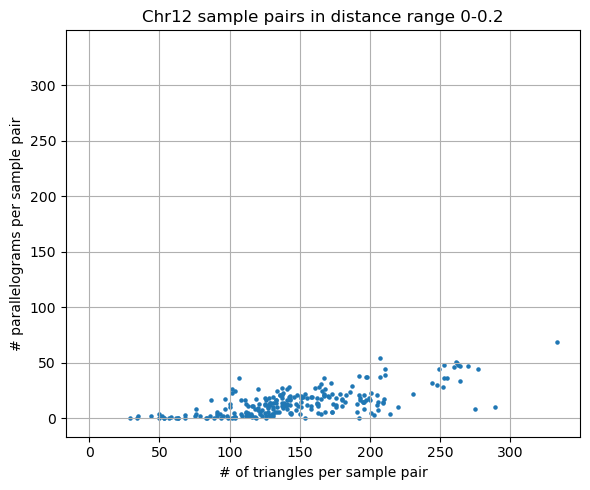

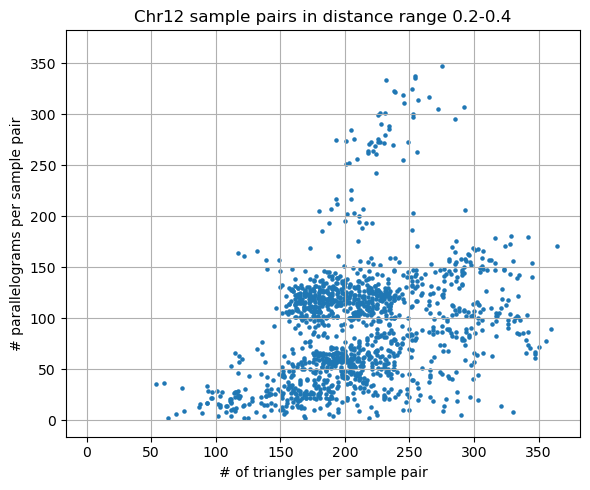

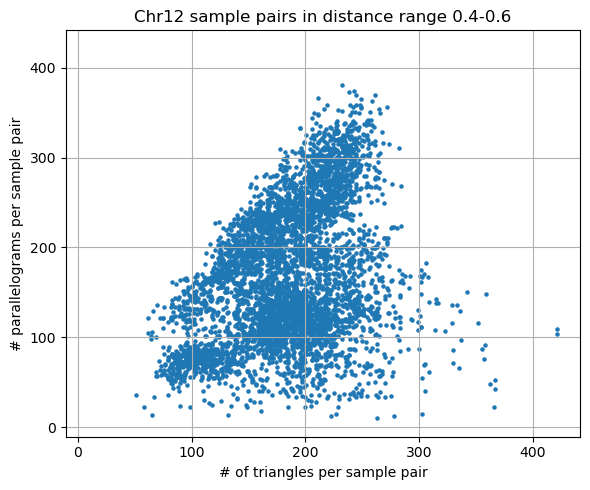

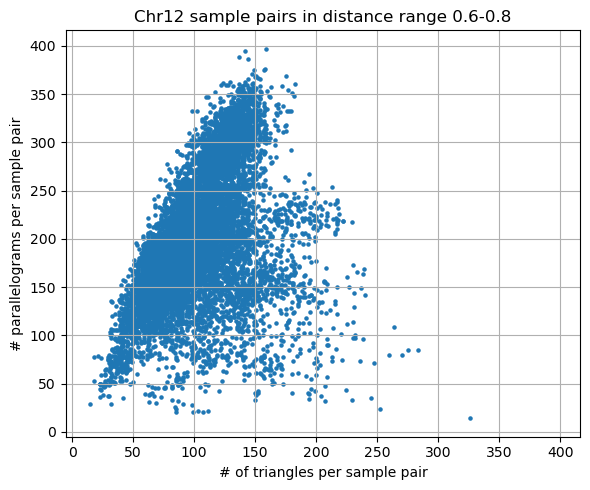

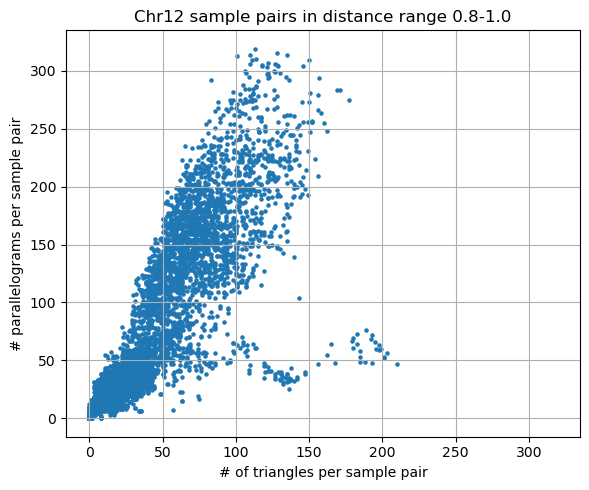

In [13]:
# Try to get a sense of whether all samples have the same ratio of parallelograms to triangles, or if their = number 
# is dominated by a few samples 

# Define bins
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"]

df_sv_sorted["dist_bin"] = pd.cut(df_sv_sorted["dist"], bins=bins, labels=labels, include_lowest=True)

# Count events for each sample pair
grouped = df_sv_sorted.groupby(["sample1", "sample2", "dist_bin"]).agg(
    x_events=("diff", lambda s: (s == -1).sum()),
    y_events=("diff", lambda s: (s > 0.1).sum())
).reset_index()

print(grouped.head())
# Scatter plots for each bin
for bin_label in labels:
    subset = grouped[grouped["dist_bin"] == bin_label]
    
    if subset.empty:
        continue
    
    plt.figure(figsize=(6,5))
    plt.scatter(subset["x_events"], subset["y_events"], s=5)

    #  dynamic equal axis ranges 
    min_val = min(subset["x_events"].min(), subset["y_events"].min())
    max_val = max(subset["x_events"].max(), subset["y_events"].max())

    # Add a small padding
    padding = (max_val - min_val) * 0.05
    plt.xlim(min_val - padding, max_val + padding)
    plt.ylim(min_val - padding, max_val + padding)

    plt.xlabel("# of triangles per sample pair")
    plt.ylabel("# parallelograms per sample pair")
    plt.title(f"Chr12 sample pairs in distance range {bin_label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()